In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import argparse
import imutils
import glob

In [8]:
# Resize window to display all image
def ResizeWithAspectRatio(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    return cv2.resize(image, dim, interpolation=inter)

In [9]:
# Read image and turn to grayscale
def readgray(image):
    img = cv2.imread(image)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [10]:
# Read image and turn to grayscale
def resizeshow(window, img, resize=False, width=1000):
    if resize:
        img = ResizeWithAspectRatio(img, width)
    cv2.imshow(window, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [11]:
# Read surface image
img = readgray('surfacedata/contrastcrop/Nr385.jpg')

resizeshow("Image", img, resize=True)

In [12]:
# Find and Plot histogram
def imghist(img, title="", xlabel='bins', ylabel='# of pixels'):
    hist = cv2.calcHist(img,[0],None,[256],[0,256])
    plt.subplot(121)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(hist)
    plt.show()

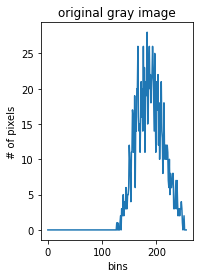

In [15]:
# find histogram of grayscale and display
imghist(img, title='original gray image')

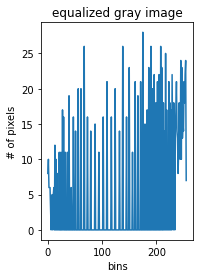

In [16]:
# Normalise brightness and increase contrast
img_eqhist=cv2.equalizeHist(img)

imghist(img_eqhist, title='equalized gray image')

In [17]:
# Display enhanced image
resizeshow("Enhanced Image", img_eqhist, resize=True)

In [22]:
# read and gray and normalize in one step
def onestepequalize(image):
    img = readgray(image)
    return cv2.equalizeHist(img)

In [25]:
# read and equalize template
tempimg = onestepequalize('surfacedata/template/Nr385.jpg')
resizeshow("Enhanced Template", tempimg, resize=True)

In [ ]:
# Attempt to do multiscale template match using enhanced images

# Below is from website in case I want to do this in command line (which i probably do :( )
# construct the argument parser and parse the arguments 
# ap = argparse.ArgumentParser()
# ap.add_argument("-t", "--template", required=True, help="Path to template image")
# ap.add_argument("-i", "--images", required=True,
# 	help="Path to images where template will be matched")
# ap.add_argument("-v", "--visualize",
# 	help="Flag indicating whether or not to visualize each iteration")
# args = vars(ap.parse_args())

(tH, tW) = tempimg.shape[:2]
# Below is modified from website

# loop over the images to find the template in
#for imagePath in glob.glob(args["images"] + "/*.jpg"):

	# load the image, convert it to grayscale, and initialize the
	# bookkeeping variable to keep track of the matched region
    
visualize = False
found = None
# loop over the scales of the image
for scale in np.linspace(0.2, 1.0, 20)[::-1]:
    # resize the image according to the scale, and keep track
    # of the ratio of the resizing
    resized = imutils.resize(img_eqhist, width = int(img_eqhist.shape[1] * scale))
    r = img_eqhist.shape[1] / float(resized.shape[1])
    # if the resized image is smaller than the template, then break
    # from the loop
    if resized.shape[0] < tH or resized.shape[1] < tW:
        break
    # detect edges in the resized, grayscale image and apply template
    # matching to find the template in the image
    # edged = cv2.Canny(resized, 50, 200) NO NEED TO DETECT EDGES
    result = cv2.matchTemplate(resized, tempimg, cv2.TM_CCOEFF)
    (_, maxVal, _, maxLoc) = cv2.minMaxLoc(result)
    # check to see if the iteration should be visualized
    if not "visualize":
        # draw a bounding box around the detected region
        clone = np.dstack([resized, resized, resized])
        cv2.rectangle(clone, (maxLoc[0], maxLoc[1]),
            (maxLoc[0] + tW, maxLoc[1] + tH), (0, 0, 255), 2)
        cv2.imshow("Visualize", clone)
        cv2.waitKey(0)
    # if we have found a new maximum correlation value, then update
    # the bookkeeping variable
    if found is None or maxVal > found[0]:
        found = (maxVal, maxLoc, r)
# unpack the bookkeeping variable and compute the (x, y) coordinates
# of the bounding box based on the resized ratio
(_, maxLoc, r) = found
(startX, startY) = (int(maxLoc[0] * r), int(maxLoc[1] * r))
(endX, endY) = (int((maxLoc[0] + tW) * r), int((maxLoc[1] + tH) * r))
# draw a bounding box around the detected result and display the image
cv2.rectangle(img_eqhist, (startX, startY), (endX, endY), (0, 0, 255), 2)
cv2.imshow("Image", img_eqhist)
cv2.waitKey(0)

In [21]:
# Using Contrast Limited Adaptive Histogram Equalization (CLAHE) 

clahe=cv2.createCLAHE(clipLimit=40) # 40 is default
gray_img_clahe=clahe.apply(gray_img_eqhist)

imgrs = ResizeWithAspectRatio(gray_img_clahe, width=1000)
cv2.imshow("Images",imgrs)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [23]:
# Attempting to separate foreground and background with threshholding
th=80
max_val=255
ret, o1 = cv2.threshold(gray_img_clahe, th, max_val, cv2.THRESH_BINARY)
cv2.putText(o1,"Thresh_Binary",(40,100),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),3,cv2.LINE_AA)
ret, o2 = cv2.threshold(gray_img_clahe, th, max_val, cv2.THRESH_BINARY_INV)
cv2.putText(o2,"Thresh_Binary_inv",(40,100),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),3,cv2.LINE_AA)
ret, o3 = cv2.threshold(gray_img_clahe, th, max_val, cv2.THRESH_TOZERO)
cv2.putText(o3,"Thresh_Tozero",(40,100),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),3,cv2.LINE_AA)
ret, o4 = cv2.threshold(gray_img_clahe, th, max_val, cv2.THRESH_TOZERO_INV)
cv2.putText(o4,"Thresh_Tozero_inv",(40,100),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),3,cv2.LINE_AA)
ret, o5 = cv2.threshold(gray_img_clahe, th, max_val, cv2.THRESH_TRUNC)
cv2.putText(o5,"Thresh_trunc",(40,100),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),3,cv2.LINE_AA)
ret ,o6=  cv2.threshold(gray_img_clahe, th, max_val,  cv2.THRESH_OTSU)
cv2.putText(o6,"Thresh_OSTU",(40,100),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),3,cv2.LINE_AA)

final=np.concatenate((o1,o2,o3),axis=1)
final1=np.concatenate((o4,o5,o6),axis=1)

cv2.imwrite("surfaceenhance/thimg1.jpg",final)
cv2.imwrite("surfaceenhance/thimg2.jpg",final1)

True

In [24]:
# Attempt adaptive thresholding to deal with different illumination
thresh1 = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
thresh2 = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 31, 3)
thresh3 = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 13, 5)
thresh4 = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 4)

final=np.concatenate((thresh1,thresh2,thresh3,thresh4),axis=1)
cv2.imwrite('surfaceenhance/rect.jpg',final)

True